In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import KFold, cross_val_score, GroupKFold, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from tqdm import tqdm
import math
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
cases = pd.read_csv('time_series_covid19_confirmed_global.csv')
cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,444,484,521,555,607,665,714,784,840,906
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,400,409,416,433,446,467,475,494,518,539
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,564,583,601,601,638,646,659,673,673,696
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,19,19


In [3]:
deaths = pd.read_csv('time_series_covid19_deaths_global.csv')
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,14,15,15,18,18,21,23,25,30,30
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,22,23,23,23,23,23,24,25,26,26
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,205,235,256,275,293,313,326,336,348,364
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,23,25,26,26,29,29,31,33,33,35
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [4]:
countries = pd.read_excel('EF.xlsx')[:193]
countries.head(2)

,English short,French short,English formal,French formal
0,Afghanistan,Afghanistan (l'),the Islamic Republic of Afghanistan,la République islamique d'Afghanistan
1,Albania,Albanie (l'),the Republic of Albania,la République d'Albanie


In [5]:
# Which regions in the JHU data have direct matches in countries?
print(deaths.shape, deaths['Country/Region'].unique().shape)

(264, 91) (185,)


In [6]:
print(deaths.loc[deaths['Country/Region'].isin(countries['English short'].values)]['Country/Region'].unique().shape)

(152,)


In [7]:
# For those with direct matches, add a new column ['Territory']
deaths['Territory'] = ''
for c in deaths.loc[deaths['Country/Region'].isin(countries['English short'].values)]['Country/Region'].unique():
  deaths.loc[deaths['Country/Region'] == c, 'Territory'] = c

# Same for cases
cases['Territory'] = ''
for c in cases.loc[cases['Country/Region'].isin(countries['English short'].values)]['Country/Region'].unique():
  cases.loc[cases['Country/Region'] == c, 'Territory'] = c

deaths.loc[deaths['Country/Region']=='Taiwan*', 'Territory'] = 'Taiwan'
cases.loc[cases['Country/Region']=='Taiwan*', 'Territory'] = 'Taiwan'

In [8]:
# The problem ones we need to reconcile manually:
print(deaths.loc[~deaths['Country/Region'].isin(countries['English short'].values)]['Country/Region'].unique())

['Bahamas' 'Bolivia' 'Brunei' 'Central African Republic'
 'Congo (Brazzaville)' 'Congo (Kinshasa)' "Cote d'Ivoire"
 'Diamond Princess' 'Dominican Republic' 'Gambia' 'Holy See' 'Iran'
 'Korea, South' 'Moldova' 'Netherlands' 'Niger' 'Philippines' 'Russia'
 'Sudan' 'Taiwan*' 'Tanzania' 'United Arab Emirates' 'United Kingdom' 'US'
 'Venezuela' 'Vietnam' 'Syria' 'Laos' 'West Bank and Gaza' 'Kosovo'
 'Burma' 'MS Zaandam' 'Western Sahara']


In [9]:
# Add them manually:
deaths.loc[deaths['Country/Region'] == 'United Arab Emirates', 'Territory'] = 'United Arab Emirates (the)'
deaths.loc[deaths['Country/Region'] == 'Philippines', 'Territory'] = 'Philippines (the)'
deaths.loc[deaths['Country/Region'] == 'Dominican Republic', 'Territory'] = 'Dominican Republic (the)'
deaths.loc[deaths['Country/Region'] == 'Brunei', 'Territory'] = 'Brunei Darussalam'
deaths.loc[deaths['Country/Region'] == 'US', 'Territory'] = 'United States of America (the)'
deaths.loc[deaths['Country/Region'] == 'Iran', 'Territory'] = 'Iran (Islamic Republic of)'
deaths.loc[deaths['Country/Region'] == 'Korea, South', 'Territory'] = "Democratic People's Republic of Korea (the)" # IS this right?
deaths.loc[deaths['Country/Region'] == 'Vietnam', 'Territory'] = 'Viet Nam'
deaths.loc[deaths['Country/Region'] == 'Russia', 'Territory'] = 'Russian Federation (the)'
deaths.loc[deaths['Country/Region'] == 'Moldova', 'Territory'] = 'Republic of Moldova (the)'
deaths.loc[deaths['Country/Region'] == 'Bolivia', 'Territory'] = 'Bolivia (Plurinational State of)'
deaths.loc[deaths['Country/Region'] == 'United Kingdom', 'Territory'] = 'United Kingdom of Great Britain and Northern Ireland (the)'
deaths.loc[deaths['Country/Region'] == 'Congo (Kinshasa)', 'Territory'] = 'Democratic Republic of the Congo (the)' # <<< Please check
deaths.loc[deaths['Country/Region'] == "Cote d'Ivoire", 'Territory'] = "Côte d'Ivoire"
deaths.loc[deaths['Country/Region'] == 'Sudan', 'Territory'] = "South Sudan" #?
deaths.loc[deaths['Country/Region'] == 'Venezuela', 'Territory'] = "Venezuela (Bolivarian Republic of)"
deaths.loc[deaths['Country/Region'] == 'Central African Republic', 'Territory'] = 'Central African Republic (the)'
deaths.loc[deaths['Country/Region'] == 'Congo (Brazzaville)', 'Territory'] = 'Congo (the)'
deaths.loc[deaths['Country/Region'] == 'Netherlands', 'Territory'] = 'Netherlands (the)'
deaths.loc[deaths['Country/Region'] == 'Tanzania', 'Territory'] = 'United Republic of Tanzania (the)'
deaths.loc[deaths['Country/Region'] == 'Gambia', 'Territory'] = 'Gambia (the)'
deaths.loc[deaths['Country/Region'] == 'Bahamas', 'Territory'] = 'Bahamas (the)'
deaths.loc[deaths['Country/Region'] == 'Niger', 'Territory'] = 'Niger (the)'
deaths.loc[deaths['Country/Region'] == 'Syria', 'Territory'] = 'Syrian Arab Republic (the)'
deaths.loc[deaths['Country/Region'] == 'Laos', 'Territory'] = "Lao People's Democratic Republic (the)"

# Drop those without a country match (!! - check output to make sure we aren't missing new additions)
print('Dropping', deaths.loc[deaths['Territory'] == '']['Country/Region'].unique())
print(deaths.shape)
deaths=deaths.loc[deaths['Territory']!= '']
print(deaths.shape)

# And for cases
# Add them manually:
cases.loc[cases['Country/Region'] == 'United Arab Emirates', 'Territory'] = 'United Arab Emirates (the)'
cases.loc[cases['Country/Region'] == 'Philippines', 'Territory'] = 'Philippines (the)'
cases.loc[cases['Country/Region'] == 'Dominican Republic', 'Territory'] = 'Dominican Republic (the)'
cases.loc[cases['Country/Region'] == 'Brunei', 'Territory'] = 'Brunei Darussalam'
cases.loc[cases['Country/Region'] == 'US', 'Territory'] = 'United States of America (the)'
cases.loc[cases['Country/Region'] == 'Iran', 'Territory'] = 'Iran (Islamic Republic of)'
cases.loc[cases['Country/Region'] == 'Korea, South', 'Territory'] = "Democratic People's Republic of Korea (the)" # IS this right?
cases.loc[cases['Country/Region'] == 'Vietnam', 'Territory'] = 'Viet Nam'
cases.loc[cases['Country/Region'] == 'Russia', 'Territory'] = 'Russian Federation (the)'
cases.loc[cases['Country/Region'] == 'Moldova', 'Territory'] = 'Republic of Moldova (the)'
cases.loc[cases['Country/Region'] == 'Bolivia', 'Territory'] = 'Bolivia (Plurinational State of)'
cases.loc[cases['Country/Region'] == 'United Kingdom', 'Territory'] = 'United Kingdom of Great Britain and Northern Ireland (the)'
cases.loc[cases['Country/Region'] == 'Congo (Kinshasa)', 'Territory'] = 'Democratic Republic of the Congo (the)' # <<< Please check
cases.loc[cases['Country/Region'] == "Cote d'Ivoire", 'Territory'] = "Côte d'Ivoire"
cases.loc[cases['Country/Region'] == 'Sudan', 'Territory'] = "South Sudan" #?
cases.loc[cases['Country/Region'] == 'Venezuela', 'Territory'] = "Venezuela (Bolivarian Republic of)"
cases.loc[cases['Country/Region'] == 'Central African Republic', 'Territory'] = 'Central African Republic (the)'
cases.loc[cases['Country/Region'] == 'Congo (Brazzaville)', 'Territory'] = 'Congo (the)'
cases.loc[cases['Country/Region'] == 'Netherlands', 'Territory'] = 'Netherlands (the)'
cases.loc[cases['Country/Region'] == 'Tanzania', 'Territory'] = 'United Republic of Tanzania (the)'
cases.loc[cases['Country/Region'] == 'Gambia', 'Territory'] = 'Gambia (the)'
cases.loc[cases['Country/Region'] == 'Bahamas', 'Territory'] = 'Bahamas (the)'
cases.loc[cases['Country/Region'] == 'Niger', 'Territory'] = 'Niger (the)'
cases.loc[cases['Country/Region'] == 'Syria', 'Territory'] = 'Syrian Arab Republic (the)'
cases.loc[cases['Country/Region'] == 'Laos', 'Territory'] = "Lao People's Democratic Republic (the)"

# Drop those without a country match (!! - check output to make sure we aren't missing new additions)
print('Dropping', cases.loc[cases['Territory'] == '']['Country/Region'].unique())
print(cases.shape)
cases=cases.loc[cases['Territory']!= '']
print(cases.shape)

Dropping ['Diamond Princess' 'Holy See' 'West Bank and Gaza' 'Kosovo' 'Burma'
 'MS Zaandam' 'Western Sahara']
(264, 92)
(257, 92)
Dropping ['Diamond Princess' 'Holy See' 'West Bank and Gaza' 'Kosovo' 'Burma'
 'MS Zaandam' 'Western Sahara']
(264, 92)
(257, 92)


In [10]:
# Add the rest of the countries with cases set to 0 (!! Use with caution as data may be unreported)
import numpy as np

remainder = countries.loc[~countries['English short'].isin(deaths.Territory.unique())]
print('Adding:', remainder['English short'].unique())
for c in remainder['English short'].unique():
  row = pd.Series([0 for _ in range(len(deaths.columns))])
  row_df = pd.DataFrame([row])
  row_df.columns = deaths.columns
  row_df['Country/Region'] = c
  row_df['Territory'] = c
  deaths = pd.concat([deaths, row_df], ignore_index=True)
print(deaths.shape)

# And for cases
for c in remainder['English short'].unique():
  row = pd.Series([0 for _ in range(len(cases.columns))])
  row_df = pd.DataFrame([row])
  row_df.columns = cases.columns
  row_df['Country/Region'] = c
  row_df['Territory'] = c
  cases = pd.concat([cases, row_df], ignore_index=True)
print(cases.shape)

Adding: ['Comoros (the)' 'Kiribati' 'Lesotho' 'Marshall Islands (the)'
 'Micronesia (Federated States of)' 'Myanmar' 'Nauru' 'Palau'
 'Republic of Korea (the)' 'Samoa' 'Solomon Islands' 'Sudan (the)'
 'Tajikistan' 'Tonga' 'Turkmenistan' 'Tuvalu' 'Vanuatu']
(274, 92)
(274, 92)


In [11]:
# Taiwan, St. Martin, Faroe Islands, St. Barthelemy, French Polynesia, French Guiana, Mayotte, Guadeloupe, Curacao, Cayman Islands, Reunion, Aruba, monserrat, Greenland, new caledonia, Bermuda.
for r in ['St Martin', 'Faroe Islands', 'Saint Barthelemy', 'French Polynesia', 'French Guiana', 'Mayotte',
          'Guadeloupe', 'Curacao', 'Cayman Islands', 'Reunion', 'Aruba', 'Montserrat', 'Greenland', 'New Caledonia', 'Bermuda']:
  if deaths.loc[deaths['Province/State']==r].shape[0]<1:
    print(r)
  deaths.loc[deaths['Province/State']==r, 'Territory'] = r
  cases.loc[cases['Province/State']==r, 'Territory'] = r


In [12]:
!pip install countryinfo

In [13]:
from countryinfo import CountryInfo

pops = {}
fails = []

regions = sorted(deaths['Territory'].unique())
for r in regions:
  try:
    country = CountryInfo(r)
    pops[r] = country.info()['population']
  except:
    fails.append(r)
    print('No pop data for', r)

No pop data for Afghanistan
No pop data for Albania
No pop data for Algeria
No pop data for Andorra
No pop data for Angola
No pop data for Antigua and Barbuda
No pop data for Argentina
No pop data for Armenia
No pop data for Aruba
No pop data for Australia
No pop data for Austria
No pop data for Azerbaijan
No pop data for Bahamas (the)
No pop data for Bahrain
No pop data for Bangladesh
No pop data for Barbados
No pop data for Belarus
No pop data for Belgium
No pop data for Belize
No pop data for Benin
No pop data for Bermuda
No pop data for Bhutan
No pop data for Bolivia (Plurinational State of)
No pop data for Bosnia and Herzegovina
No pop data for Botswana
No pop data for Brazil
No pop data for Brunei Darussalam
No pop data for Bulgaria
No pop data for Burkina Faso
No pop data for Burundi
No pop data for Cabo Verde
No pop data for Cambodia
No pop data for Cameroon
No pop data for Canada
No pop data for Cayman Islands
No pop data for Central African Republic (the)
No pop data for Chad

In [14]:
# Adding in population as a column
cols = list(deaths.columns)
deaths['Population'] = deaths['Country/Region'].map(pops)
deaths = deaths[cols[:2]+['Territory','Population']+cols[2:-1]] # Better ordering
deaths.head()

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,Afghanistan,NaN,33.0000,65.0000,0,0,0,0,...,14,15,15,18,18,21,23,25,30,30
1,NaN,Albania,Albania,NaN,41.1533,20.1683,0,0,0,0,...,22,23,23,23,23,23,24,25,26,26
2,NaN,Algeria,Algeria,NaN,28.0339,1.6596,0,0,0,0,...,205,235,256,275,293,313,326,336,348,364
3,NaN,Andorra,Andorra,NaN,42.5063,1.5218,0,0,0,0,...,23,25,26,26,29,29,31,33,33,35
4,NaN,Angola,Angola,NaN,-11.2027,17.8739,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [15]:
# Looking at raw numbers vs pop adjusted figures
grouped = deaths.groupby('Territory').sum()
# grouped['3/12/20'].sort_values(ascending=False).head(20) # Raw numbers
(grouped['3/12/20']*1e7/deaths.groupby('Territory').mean()['Population']).sort_values(ascending=False).head(20) # Scaled by population (deaths/10M people)

Territory
Afghanistan           NaN
Albania               NaN
Algeria               NaN
Andorra               NaN
Angola                NaN
Antigua and Barbuda   NaN
Argentina             NaN
Armenia               NaN
Aruba                 NaN
Australia             NaN
Austria               NaN
Azerbaijan            NaN
Bahamas (the)         NaN
Bahrain               NaN
Bangladesh            NaN
Barbados              NaN
Belarus               NaN
Belgium               NaN
Belize                NaN
Benin                 NaN
dtype: float64

In [16]:
# Creating the 'reference' file

TEST_PERIOD = 7 # In days

test_dates = deaths.columns[-TEST_PERIOD:] # The last two weeks worth of data
countries = deaths.groupby('Territory').sum()[test_dates] # Group by country/region, and select only the columns for the test_period

# Create a new dataframe, with a Region X Date column. 
reference = pd.DataFrame({
    'Territory X Date':list(map((lambda x: ' X '.join(x)), list(countries.stack().index.to_flat_index()))), # Check output to see what this is doing
    'target':countries.stack() # The target we'll be predicting: cumulative number of cases for a given region at a given date.
}).reset_index(drop=True) # Don't need the multiIndex created with Stack
reference.to_csv('reference.csv', index=False)
reference.head()

,Territory X Date,target
0,Afghanistan X 4/11/20,18
1,Afghanistan X 4/12/20,18
2,Afghanistan X 4/13/20,21
3,Afghanistan X 4/14/20,23
4,Afghanistan X 4/15/20,25


In [17]:
# Sample submission is the same as the reference file, just with target set to 0
print(reference.target.sum())
ss = reference.copy()
ss['target'] = 0
print(ss.target.sum())
ss.to_csv('SampleSubLocal.csv', index=False)

899656
0


In [18]:
# Scoring
from sklearn.metrics import mean_absolute_error

# Create some 'predictions
predictions = ss.copy()
predictions['target'] = 42 # These would be your actual predictions

# Calculate MAE
print('MAE: ', mean_absolute_error(reference['target'], predictions['target']))

MAE:  625.1551606288448


In [19]:
train_dates = deaths.columns[6:-TEST_PERIOD] # The dates for the train perion

# Grouping by territory
country_deaths = deaths.groupby('Territory').sum()[train_dates] 
country_cases = cases.groupby('Territory').sum()[train_dates] 

# Creating the dataframe
train = pd.DataFrame({
    'Territory X Date':list(map((lambda x: ' X '.join(x)), list(country_deaths.stack().index.to_flat_index()))), 
    'target':country_deaths.stack(),
    'cases':country_cases.stack() # Added as they may be useful
}).reset_index(drop=True)

# Add Separate Region and Date columns
train['Territory'] = train['Territory X Date'].apply(lambda x: x.split(' X ')[0])
train['Date'] = train['Territory X Date'].apply(lambda x: x.split(' X ')[1])

# Saving and viewing
train.to_csv('train.csv', index=False)
train.head()

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,1/22/20
1,Afghanistan X 1/23/20,0,0,Afghanistan,1/23/20
2,Afghanistan X 1/24/20,0,0,Afghanistan,1/24/20
3,Afghanistan X 1/25/20,0,0,Afghanistan,1/25/20
4,Afghanistan X 1/26/20,0,0,Afghanistan,1/26/20


In [20]:
# Add Separate Region and Date columns
train['Territory'] = train['Territory X Date'].apply(lambda x: x.split(' X ')[0])
train['Date'] = train['Territory X Date'].apply(lambda x: x.split(' X ')[1])
train.head()

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,1/22/20
1,Afghanistan X 1/23/20,0,0,Afghanistan,1/23/20
2,Afghanistan X 1/24/20,0,0,Afghanistan,1/24/20
3,Afghanistan X 1/25/20,0,0,Afghanistan,1/25/20
4,Afghanistan X 1/26/20,0,0,Afghanistan,1/26/20


In [21]:
train.to_csv('traindata.csv', index=False)

In [22]:
train=pd.read_csv('traindata.csv',parse_dates=['Date'])
test=pd.read_csv('SampleSubmission.csv')

In [23]:
test['Date'] = test['Territory X Date'].apply(lambda x: x.split(' X ')[1])

In [24]:
test.to_csv('test.csv', index=False)

In [25]:
test=pd.read_csv('test.csv',parse_dates=['Date'])

In [26]:
test.head()

,Territory X Date,target,Date
0,Afghanistan X 03/06/20,0,2020-03-06
1,Afghanistan X 03/07/20,0,2020-03-07
2,Afghanistan X 03/08/20,0,2020-03-08
3,Afghanistan X 03/09/20,0,2020-03-09
4,Afghanistan X 03/10/20,0,2020-03-10


In [27]:
# Function to add date features
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [28]:
target = train.target

train['separator'] = 0
test['separator'] = 1

train, test = train.align(test, join = 'inner', axis = 1)

comb = pd.concat([train, test])

In [29]:
import re
add_datepart(comb, 'Date', False)

In [30]:
comb['Territory'] = comb['Territory X Date'].apply(lambda x: x.split(' X ')[0])

In [31]:
comb['Territory X Date']= comb['Territory'].map(str) + ' X ' + comb['Month'].map(str) + '/' + comb['Day'].map(str) + '/'+'20'

In [32]:
comb = pd.get_dummies(comb, columns = ['Territory'])

In [33]:
train = comb[comb.separator == 0]
test = comb[comb.separator == 1]

train.drop('separator', axis = 1, inplace = True)
test.drop('separator', axis = 1, inplace = True)

In [34]:
train.head()

,Territory X Date,target,Date,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,...,Territory_United Republic of Tanzania (the),Territory_United States of America (the),Territory_Uruguay,Territory_Uzbekistan,Territory_Vanuatu,Territory_Venezuela (Bolivarian Republic of),Territory_Viet Nam,Territory_Yemen,Territory_Zambia,Territory_Zimbabwe
0,Afghanistan X 1/22/20,0,2020-01-22,1,4,22,2,22,False,False,...,0,0,0,0,0,0,0,0,0,0
1,Afghanistan X 1/23/20,0,2020-01-23,1,4,23,3,23,False,False,...,0,0,0,0,0,0,0,0,0,0
2,Afghanistan X 1/24/20,0,2020-01-24,1,4,24,4,24,False,False,...,0,0,0,0,0,0,0,0,0,0
3,Afghanistan X 1/25/20,0,2020-01-25,1,4,25,5,25,False,False,...,0,0,0,0,0,0,0,0,0,0
4,Afghanistan X 1/26/20,0,2020-01-26,1,4,26,6,26,False,False,...,0,0,0,0,0,0,0,0,0,0


In [35]:
test.head()

,Territory X Date,target,Date,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,...,Territory_United Republic of Tanzania (the),Territory_United States of America (the),Territory_Uruguay,Territory_Uzbekistan,Territory_Vanuatu,Territory_Venezuela (Bolivarian Republic of),Territory_Viet Nam,Territory_Yemen,Territory_Zambia,Territory_Zimbabwe
0,Afghanistan X 3/6/20,0,2020-03-06,3,10,6,4,66,False,False,...,0,0,0,0,0,0,0,0,0,0
1,Afghanistan X 3/7/20,0,2020-03-07,3,10,7,5,67,False,False,...,0,0,0,0,0,0,0,0,0,0
2,Afghanistan X 3/8/20,0,2020-03-08,3,10,8,6,68,False,False,...,0,0,0,0,0,0,0,0,0,0
3,Afghanistan X 3/9/20,0,2020-03-09,3,11,9,0,69,False,False,...,0,0,0,0,0,0,0,0,0,0
4,Afghanistan X 3/10/20,0,2020-03-10,3,11,10,1,70,False,False,...,0,0,0,0,0,0,0,0,0,0


In [36]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)
data.columns.tolist()

['Territory X Date',
 'target',
 'Date',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Elapsed',
 'Territory_Afghanistan',
 'Territory_Albania',
 'Territory_Algeria',
 'Territory_Andorra',
 'Territory_Angola',
 'Territory_Antigua and Barbuda',
 'Territory_Argentina',
 'Territory_Armenia',
 'Territory_Aruba',
 'Territory_Australia',
 'Territory_Austria',
 'Territory_Azerbaijan',
 'Territory_Bahamas (the)',
 'Territory_Bahrain',
 'Territory_Bangladesh',
 'Territory_Barbados',
 'Territory_Belarus',
 'Territory_Belgium',
 'Territory_Belize',
 'Territory_Benin',
 'Territory_Bermuda',
 'Territory_Bhutan',
 'Territory_Bolivia (Plurinational State of)',
 'Territory_Bosnia and Herzegovina',
 'Territory_Botswana',
 'Territory_Brazil',
 'Territory_Brunei Darussalam',
 'Territory_Bulgaria',
 'Territory_Burkina Faso',
 'Territory_Burundi',
 'Territory_Cabo Verde',
 'Territory_Cambodia',
 'Territory_Cameroon',
 'Territory_Canada',
 'Territory_Cayman Isl

In [37]:
featurres =['Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear','Territory_China','Territory_Spain','Territory_France','Territory_United Kingdom of Great Britain and Northern Ireland (the)','Territory_Iran (Islamic Republic of)']

In [38]:
def aggregate_features(x,col_name):
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["median_"+col_name]=x[col_name].apply(np.median)
    return x  

In [39]:
for col_name in tqdm(featurres):
    train=aggregate_features(train,col_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


In [40]:
for col_name in tqdm(featurres):
    test=aggregate_features(test,col_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


target_mean = train.groupby(['Month']).mean()[['target']]
for i in list(target_mean.columns):
  target_mean.rename({i:i+"_mean"},axis=1,inplace=True)
train = train.merge(target_mean,how="left",on='Month')
test = test.merge(target_mean,how="left",on='Month')

In [41]:
train=train.drop(['Territory X Date','Date'], axis=1)
test=test.drop(['Territory X Date','Date','target'], axis=1)

In [42]:
train.head()

,target,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Elapsed,Territory_Afghanistan,...,mean_Territory_France,median_Territory_France,min_Territory_United Kingdom of Great Britain and Northern Ireland (the),max_Territory_United Kingdom of Great Britain and Northern Ireland (the),mean_Territory_United Kingdom of Great Britain and Northern Ireland (the),median_Territory_United Kingdom of Great Britain and Northern Ireland (the),min_Territory_Iran (Islamic Republic of),max_Territory_Iran (Islamic Republic of),mean_Territory_Iran (Islamic Republic of),median_Territory_Iran (Islamic Republic of)
0,0,1,4,22,2,22,False,False,1579651200,1,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
1,0,1,4,23,3,23,False,False,1579737600,1,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
2,0,1,4,24,4,24,False,False,1579824000,1,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
3,0,1,4,25,5,25,False,False,1579910400,1,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
4,0,1,4,26,6,26,False,False,1579996800,1,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0


In [43]:
test.head()

,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Elapsed,Territory_Afghanistan,Territory_Albania,...,mean_Territory_France,median_Territory_France,min_Territory_United Kingdom of Great Britain and Northern Ireland (the),max_Territory_United Kingdom of Great Britain and Northern Ireland (the),mean_Territory_United Kingdom of Great Britain and Northern Ireland (the),median_Territory_United Kingdom of Great Britain and Northern Ireland (the),min_Territory_Iran (Islamic Republic of),max_Territory_Iran (Islamic Republic of),mean_Territory_Iran (Islamic Republic of),median_Territory_Iran (Islamic Republic of)
0,3,10,6,4,66,False,False,1583452800,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
1,3,10,7,5,67,False,False,1583539200,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
2,3,10,8,6,68,False,False,1583625600,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
3,3,11,9,0,69,False,False,1583712000,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
4,3,11,10,1,70,False,False,1583798400,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0


In [44]:
X = train.drop('target', axis=1)
y = train['target']

In [93]:
from sklearn.metrics import mean_absolute_error
errcb=[]
y_pred_totcb=[]
fold=KFold(n_splits=10, random_state=1992, shuffle=True)#44
i=1

for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostRegressor(iterations = 1000, learning_rate=0.2, depth = 4)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=50, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",mean_absolute_error(y_test,preds))
    errcb.append(mean_absolute_error(y_test,preds))
    p = m.predict(test)
    y_pred_totcb.append(p)

0:	learn: 679.0597099	test: 679.0597099	test1: 560.4913728	best: 560.4913728 (0)	total: 8.84ms	remaining: 8.83s
50:	learn: 156.2064931	test: 156.2064931	test1: 178.5384858	best: 178.5384858 (50)	total: 427ms	remaining: 7.94s
100:	learn: 84.3845435	test: 84.3845435	test1: 127.9854845	best: 127.9854845 (100)	total: 891ms	remaining: 7.93s
150:	learn: 63.5401003	test: 63.5401003	test1: 108.8837535	best: 108.8680413 (149)	total: 1.34s	remaining: 7.57s
200:	learn: 55.6771174	test: 55.6771174	test1: 101.3066957	best: 101.3066957 (200)	total: 1.81s	remaining: 7.21s
250:	learn: 49.2529954	test: 49.2529954	test1: 93.2299129	best: 93.2299129 (250)	total: 2.26s	remaining: 6.74s
300:	learn: 45.4751203	test: 45.4751203	test1: 88.1279232	best: 88.1138436 (298)	total: 2.59s	remaining: 6.01s
350:	learn: 42.2869666	test: 42.2869666	test1: 82.3656761	best: 82.3656761 (350)	total: 2.86s	remaining: 5.29s
400:	learn: 39.5362653	test: 39.5362653	test1: 77.5307589	best: 77.5307589 (400)	total: 3.22s	remaining

100:	learn: 90.9043742	test: 90.9043742	test1: 88.3354579	best: 88.3354579 (100)	total: 573ms	remaining: 5.1s
150:	learn: 70.5102959	test: 70.5102959	test1: 75.4291342	best: 75.4291342 (150)	total: 995ms	remaining: 5.59s
200:	learn: 61.7382861	test: 61.7382861	test1: 71.0320932	best: 71.0261218 (199)	total: 1.48s	remaining: 5.88s
250:	learn: 54.7281876	test: 54.7281876	test1: 64.9998834	best: 64.9998834 (250)	total: 1.9s	remaining: 5.67s
300:	learn: 50.3820494	test: 50.3820494	test1: 61.8000962	best: 61.8000962 (300)	total: 2.35s	remaining: 5.46s
350:	learn: 46.3858662	test: 46.3858662	test1: 58.7562051	best: 58.7562051 (350)	total: 2.81s	remaining: 5.21s
400:	learn: 43.6386530	test: 43.6386530	test1: 56.2233506	best: 56.2156666 (399)	total: 3.25s	remaining: 4.86s
450:	learn: 40.2259373	test: 40.2259373	test1: 53.5796005	best: 53.5796005 (450)	total: 3.47s	remaining: 4.23s
500:	learn: 38.1799652	test: 38.1799652	test1: 52.1504042	best: 51.9859366 (492)	total: 3.69s	remaining: 3.67s
550

600:	learn: 33.0058799	test: 33.0058799	test1: 64.0740625	best: 64.0740625 (600)	total: 2.98s	remaining: 1.98s
650:	learn: 31.6299295	test: 31.6299295	test1: 63.2965040	best: 63.2124787 (647)	total: 3.19s	remaining: 1.71s
700:	learn: 30.5780434	test: 30.5780434	test1: 62.4864354	best: 62.4864354 (700)	total: 3.42s	remaining: 1.46s
750:	learn: 29.3885808	test: 29.3885808	test1: 61.5509260	best: 61.5509260 (750)	total: 3.62s	remaining: 1.2s
800:	learn: 28.2565403	test: 28.2565403	test1: 61.4581257	best: 61.1378580 (773)	total: 3.88s	remaining: 965ms
850:	learn: 27.4149501	test: 27.4149501	test1: 60.8582850	best: 60.7414308 (834)	total: 4.19s	remaining: 734ms
900:	learn: 26.3836976	test: 26.3836976	test1: 60.7113648	best: 60.6503321 (877)	total: 4.42s	remaining: 486ms
950:	learn: 25.0684330	test: 25.0684330	test1: 60.0805089	best: 60.0805089 (950)	total: 4.64s	remaining: 239ms
999:	learn: 24.1702483	test: 24.1702483	test1: 59.9676120	best: 59.8556937 (994)	total: 4.86s	remaining: 0us

bes

In [94]:
np.mean(errcb)

10.876118098527236

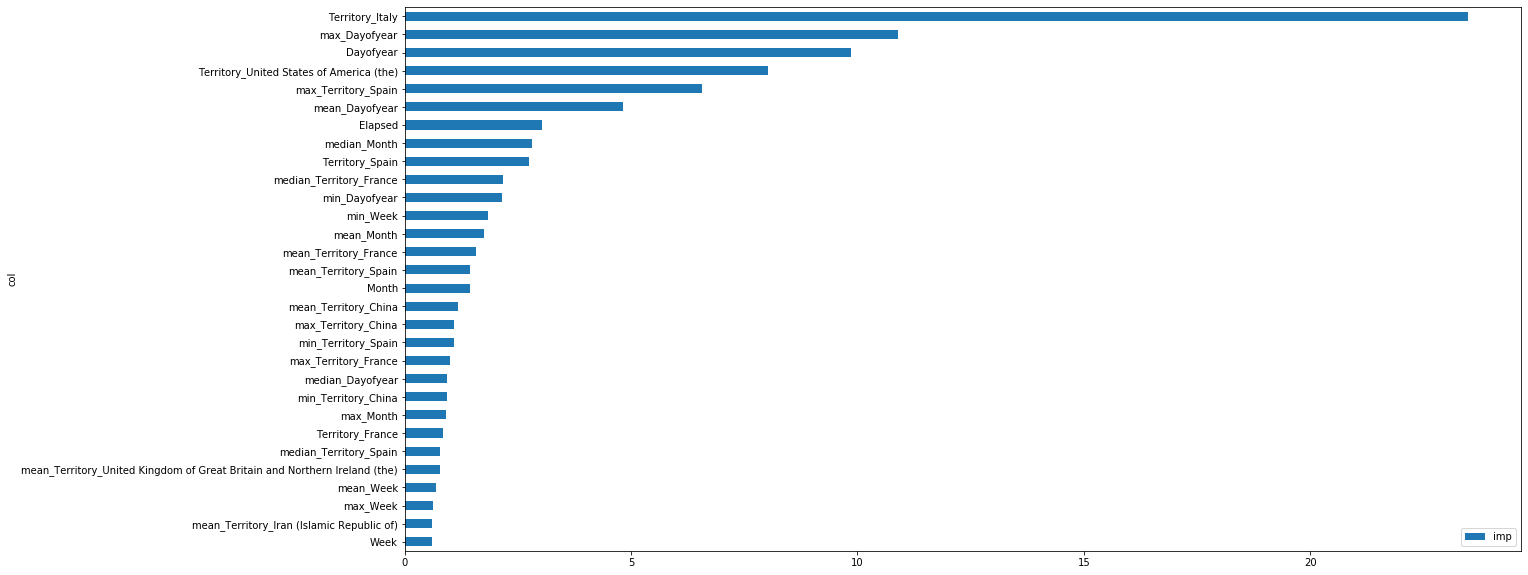

In [95]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')  

In [96]:
dates = pd.date_range(start='2020-03-06', end='2020-06-07', freq='1d')
ids = []
for c in sorted(deaths['Territory'].unique()):
  for d in dates:
    ids.append(c + ' X ' + d.strftime('%m/%d/%y'))
ss = pd.DataFrame({
    'Territory X Date':ids,
    'target':np.mean(y_pred_totcb,0)
})
ss.to_csv('S1.csv', index=False)
ss.head()

,Territory X Date,target
0,Afghanistan X 03/06/20,-2.170558
1,Afghanistan X 03/07/20,-1.587512
2,Afghanistan X 03/08/20,-0.609915
3,Afghanistan X 03/09/20,-1.447666
4,Afghanistan X 03/10/20,-1.116434


In [97]:
ss =pd.read_csv('S1.csv');ss.head(2)

,Territory X Date,target
0,Afghanistan X 03/06/20,-2.170558
1,Afghanistan X 03/07/20,-1.587512


In [98]:
ss['Date'] = ss['Territory X Date'].apply(lambda x: x.split(' X ')[1])

In [99]:
def add_subdate(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Month', 'Day'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [100]:
add_subdate(ss, 'Date', False)

In [101]:
import datetime as dt
ss['Territory'] = ss['Territory X Date'].apply(lambda x: x.split(' X ')[0])

In [102]:
ss['Territory X Date']= ss['Territory'].map(str) + ' X ' + ss['Month'].map(str) + '/' + ss['Day'].map(str) + '/'+'20'

In [103]:
ss =ss[['Territory X Date','target']]

In [104]:
ss.to_csv('first14stdnorenedata.csv', index=False)